In [ ]:
#!pip install opencv-python tensorflow keras numpy scikit-learn scikit-image torch torchvision torchaudio pillow

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torch.nn as nn
import os
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
#from google.colab import files


# --- 1. Define Dataset ---
class ArtDataset(Dataset):
    def __init__(self, images):
        self.images = images.astype(np.float32) #/ 255.0  # Normalize to [0,1]
        self.transform = transforms.ToTensor()

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]  # Shape: (img_size, img_size, channels)
        img = self.transform(img)  # Convert to (C, H, W)
        return img


class AffineCouplingLayer(nn.Module):
    def __init__(self, mask, width):
        super().__init__()
        self.mask = mask
        self.n = len(mask)
        self.width = width

        self.scale_layer1 = nn.Linear(self.n, self.width)
        self.scale_layer2 = nn.Linear(self.width, self.width)
        self.scale_layer3 = nn.Linear(self.width, self.n)

        self.trans_layer1 = nn.Linear(self.n, self.width)
        self.trans_layer2 = nn.Linear(self.width, self.width)
        self.trans_layer3 = nn.Linear(self.width, self.n)

    def scale(self, x):
        x = x * self.mask
        activation = nn.Tanh()
        x = activation(self.scale_layer1(x))
        x = activation(self.scale_layer2(x))
        x = self.scale_layer3(x)
        return x

    def translation(self, x):
        x = x * self.mask
        activation = nn.Tanh()
        x = activation(self.trans_layer1(x))
        x = activation(self.trans_layer2(x))
        x = self.trans_layer3(x)
        return x

    def forward(self, z):
        s = self.scale(z)
        t = self.translation(z)
        x = self.mask * z + (1 - self.mask) * (z * torch.exp(s) + t)
        logdet = torch.sum((1 - self.mask) * s, dim=1)
        return x, logdet

    def inverse(self, x):
        s = self.scale(x)
        t = self.translation(x)
        z = self.mask * x + (1 - self.mask) * ((x - t) * torch.exp(-s))
        logdet = torch.sum((1 - self.mask) * (-s), dim=1)
        return z, logdet

class SimpleNN(nn.Module):
    def __init__(self, num_affine_layers, width, mask1, mask2):
        super().__init__()
        module_list = nn.ModuleList()
        for _ in range(num_affine_layers):
            module_list.append(AffineCouplingLayer(mask1, width))
            module_list.append(AffineCouplingLayer(mask2, width))
        self.module_list = module_list

    def forward(self, z):
        log_det = 0.0
        for layer in self.module_list:
            z, mini_log_det = layer.forward(z)
            log_det += mini_log_det
        return z, log_det

    def inverse(self, x):
        log_det = 0.0
        n = len(self.module_list)
        for i in range(n):
            layer = self.module_list[n - i - 1]
            x, mini_log_det = layer.inverse(x)
            log_det += mini_log_det
        return x, log_det


# --- 4. Load and Process Data ---
def load_images(image_array, batch_size=32):
    dataset = ArtDataset(image_array)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader
    

# Parameters
torch.manual_seed(1)
max_epochs = 1000
learning_rate = 1e-3
width = 64
num_affine_layers = 5
noise_amplitude = 1e-2 
#img_size = 128


# Load images from file
images_np = np.load('Modigliani_paintings.npy')

num_img, img_size, _ , channels = images_np.shape

train_loader = load_images(images_np, batch_size=16)

#dataset = ImageFolder(root=image_dir, transform=transform)
#train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Generate checkerboard masks
mask1 = np.tile((np.arange(img_size) % 2)[:, None], (1, img_size))
mask2 = 1 - mask1
mask1 = torch.tensor(np.repeat(mask1[None, :, :], 3, axis=0).flatten(), dtype=torch.float32)
mask2 = torch.tensor(np.repeat(mask2[None, :, :], 3, axis=0).flatten(), dtype=torch.float32)

net = SimpleNN(num_affine_layers, width, mask1, mask2)
optimizer = torch.optim.Adam(net.parameters(), lr=learning_rate)

for epoch in range(max_epochs):
    train_loss = 0.0
    for images in train_loader:
        images = torch.flatten(images, 1)
        images += noise_amplitude * torch.randn(images.shape)
        z, logdet = net.inverse(images)
        loss = torch.log(z.new_tensor([2 * np.pi])) + torch.mean(torch.sum(0.5 * z ** 2, -1) - logdet)
        train_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    if epoch % 1 == 0:
        print(f"\rEpoch {epoch}: loss = {train_loss}",end=" ")

torch.save(net, "network_custom.pth")

# Generate and Plot Images - Fixed version
num_images = 10
z = torch.normal(mean=0, std=1, size=(num_images, channels * img_size * img_size))
with torch.no_grad():
    generated_images, _ = net.forward(z)
    generated_images = generated_images.reshape(num_images, channels, img_size, img_size)  # Reshape correctly
    generated_images = generated_images.permute(0, 2, 3, 1)  # Change to (N, H, W, C) for plotting
    generated_images = generated_images.cpu().numpy()  # Convert to numpy

# Plotting
fig, axes = plt.subplots(5, 2, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < num_images:  # Ensure we don't exceed number of images
        img = generated_images[i]
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for better visualization
        ax.imshow(img)  # Removed cmap='winter' since RGB doesn't need it
        ax.axis("off")
plt.suptitle("Generated Samples")
plt.tight_layout()
plt.savefig("generated_samples.png")  # Save before show
plt.show()

Epoch 7: loss = -598400.1015625    

In [8]:
img.shape

(64, 64, 3)

In [ ]:
"""GENERATE NEW IMAGES"""

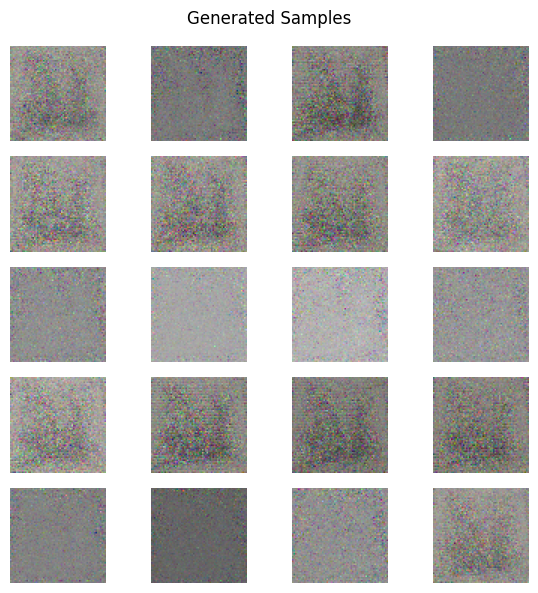

In [13]:
# Generate and Plot Images - Fixed version
num_images = 20
z = torch.normal(mean=0, std=1, size=(num_images, channels * img_size * img_size))
with torch.no_grad():
    generated_images, _ = net.forward(z)
    generated_images = generated_images.reshape(num_images, channels, img_size, img_size)  # Reshape correctly
    generated_images = generated_images.permute(0, 2, 3, 1)  # Change to (N, H, W, C) for plotting
    generated_images = generated_images.cpu().numpy()  # Convert to numpy

# Plotting
fig, axes = plt.subplots(5, 4, figsize=(6, 6))
for i, ax in enumerate(axes.flat):
    if i < num_images:  # Ensure we don't exceed number of images
        img = generated_images[i]
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for better visualization
        ax.imshow(img)  # Removed cmap='winter' since RGB doesn't need it
        ax.axis("off")
plt.suptitle("Generated Samples")
plt.tight_layout()
plt.savefig("generated_samples.png")  # Save before show
plt.show()